In [4]:
# Import libraries and functions
import random
import math
import torch
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# General Setup
torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pd.set_option('display.max_rows', 500)
print(device)

cuda


In [5]:
# load and modify the data
pokemon_train = pd.read_csv('C:\\Users\\Kkda\\Desktop\\Stat 441 Final Project\\Pokemon_train.csv')
pokemon_test = pd.read_csv('C:\\Users\\Kkda\\Desktop\\Stat 441 Final Project\\Pokemon_test.csv')

# Define columns
to_drop = ["has_gender","sprite_perimeter","sprite_size","sprite_overflow_vertical","sprite_overflow_horizontal","height_m"]

categorical = ['type_2','status']

weakness = ['damage_from_normal', 'damage_from_fire', 'damage_from_water', 'damage_from_electric',
            'damage_from_grass', 'damage_from_ice', 'damage_from_fighting', 'damage_from_poison',
            'damage_from_ground', 'damage_from_flying', 'damage_from_psychic', 'damage_from_bug','damage_from_rock',
            'damage_from_ghost', 'damage_from_dragon', 'damage_from_dark','damage_from_steel', 'damage_from_fairy']

# Drop unwanted variables
pokemon_train = pokemon_train.drop(columns=to_drop+weakness)
pokemon_test = pokemon_test.drop(columns=to_drop+weakness)

# Define class and features
y_train = pokemon_train['type_1']; X_train = pokemon_train.drop(['type_1'],axis=1)
y_test = pokemon_test['type_1']; X_test = pokemon_test.drop(['type_1'],axis=1)

# Encode categorical variables
y_train = pd.get_dummies(y_train); X_train = pd.get_dummies(X_train,columns=categorical)
y_test = pd.get_dummies(y_test); X_test = pd.get_dummies(X_test,columns=categorical)


# Scale numerical variables
scaler = StandardScaler()
ending = sum(X_train.dtypes == ["float64"]*X_train.shape[1])
X_train.iloc[:,:ending] = scaler.fit_transform(X_train.iloc[:,:ending])
X_test.iloc[:,:ending] = scaler.fit_transform(X_test.iloc[:,:ending])

# Convert training and testing data into PyTorch tensor
y_train = torch.tensor(y_train.values).float(); X_train = torch.tensor(X_train.values).float()
y_test = torch.tensor(y_test.values).float(); X_test = torch.tensor(X_test.values).float()

# Set up number classes and features
n_class = 18
n_feature = X_test.shape[1]

In [6]:
# Define model
class NN(nn.Module):
    
    def __init__(self, node_list,drop):
        super(NN, self).__init__()
        
        self.layers = nn.ModuleList()
        for i in range(1, len(node_list)):
            self.layers.append(nn.Linear(node_list[i-1], node_list[i]))
        
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(p=drop)
        
    def forward(self, x):
        out = x
        for i in range(len(self.layers)-1):
            out = self.layers[i](out)
            out = self.activation(out)
        out = self.layers[len(self.layers)-1](out)
        return out

In [7]:
# Prediction function
def predict(model, X, y):
    
    # Set up loader
    test_dataset = TensorDataset(X,y)
    loader = DataLoader(test_dataset, batch_size = 9999, shuffle = False)
    
    # Set model to evaluation
    model.eval()
    
    # Evaluate model
    num_correct = 0
    num_samples = 0
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            x = x.reshape(x.shape[0], -1)
            model_result = model(x)
            _, prediction = model_result.max(1)
            _, actual = y.max(1)
            num_correct += (prediction == actual).sum()
            num_samples += prediction.size(0)
    
    # Set model to training
    model.train()
    
    return prediction.cpu().numpy(), actual.cpu().numpy(), num_correct/num_samples

In [8]:
# Training function
# Input: Model hyper parameters, training and testing data
# Output: Model, Loss
def train_model(learning_rate, num_epochs, batch_size, node_list, drop, X, y):

    # Create the model
    model = NN([n_feature]+node_list+[n_class], drop).to(device)

    # Set up loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Set up data loader
    train_dataset = TensorDataset(X,y)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    
    # Initialize loss
    loss = []
    
    # Set up early stopping
    early_stopping = False
    prev_loss = float('inf')
    patience = 5
    epochs_since_improvement = 0
    min_delta = 0.001
    
    # Train model
    for epoch in range(num_epochs):
        for batch_idx, (data, targets) in enumerate(train_loader):
            # Get data to cuda if possible
            data = data.to(device = device)
            targets = targets.to(device = device)

            # Reshape data
            data = data.reshape(data.shape[0], -1)
            
            # Forward propagation
            model_result = model(data)
            current_loss = criterion(model_result, targets)
            
            # Zero previous gradients
            optimizer.zero_grad()
            
            # back-propagation
            current_loss.backward()
            
            # optimize
            optimizer.step()
        
        # Record loss of the current epoch
        loss.append(float(current_loss.item()))
        
        # Check if model stopped improving
        if prev_loss - current_loss.item() < min_delta:
            epochs_since_improvement += 1
        else:
            epochs_since_improvement = 0
        
        if prev_loss < current_loss.item():
            prev_loss = current_loss.item()
        
        if epochs_since_improvement >= patience or current_loss.item() < 0.001:
            loss = loss + [current_loss.item()]*(num_epochs-len(loss))
            break
            
    return model, loss

In [9]:
def model_examination(learning_rate, num_epochs, batch_size, node_list, drop,
                      X_train, y_train, X_test, y_test):
    # Train model
    model, loss = train_model(learning_rate, num_epochs, batch_size, node_list, drop, X_train, y_train)
    # Estimate model accuracy
    pred, actual, accuracy = predict(model, X_test, y_test)
    
    return model, loss, pred, actual, accuracy.cpu().item()

# Check if function works properly

NN(
  (layers): ModuleList(
    (0): Linear(in_features=50, out_features=1050, bias=True)
    (1): Linear(in_features=1050, out_features=1050, bias=True)
    (2): Linear(in_features=1050, out_features=18, bias=True)
  )
  (activation): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)
0.4832535684108734


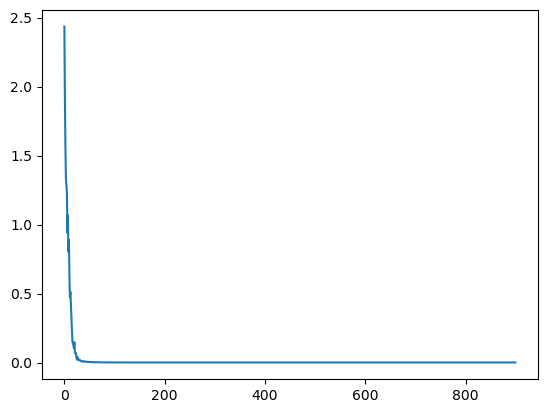

In [55]:
# Check if function works properly

# Model parameters
learning_rate,num_epochs,batch_size,drop = 0.002,900,250,0.2
node_list = [1050,1050]

model, loss, pred, actual, accuracy = model_examination(learning_rate, num_epochs, batch_size, node_list, drop,
                                                        X_train, y_train, X_test, y_test)
print(model)
print(accuracy)
plt.plot(loss)

# Examine how number of layers and nodes affect the performance

In [32]:
max_hidden_layer = 5
node_max_multiplier = 19
learning_rate,num_epochs,batch_size,drop = 0.002,550,250,0.2
acc_node_layer = [[0] * node_max_multiplier for _ in range(max_hidden_layer)]

for i in tqdm(range(max_hidden_layer)):
    for j in tqdm(range(node_max_multiplier),leave=False):
        node_list = [100+50*j]*(i+1)
        accuracy = 0
        count = 100
        for k in tqdm(range(count),leave=False):
            X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X_train,y_train,test_size=0.2,
                                                                                   random_state=random.seed(time.time()))
            _,_,_,_, acc_temp = model_examination(learning_rate, num_epochs, batch_size, node_list, drop,
                                                  X_train_temp, y_train_temp, X_test_temp, y_test_temp)
            accuracy += acc_temp
        acc_node_layer[i][j] = accuracy/count

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

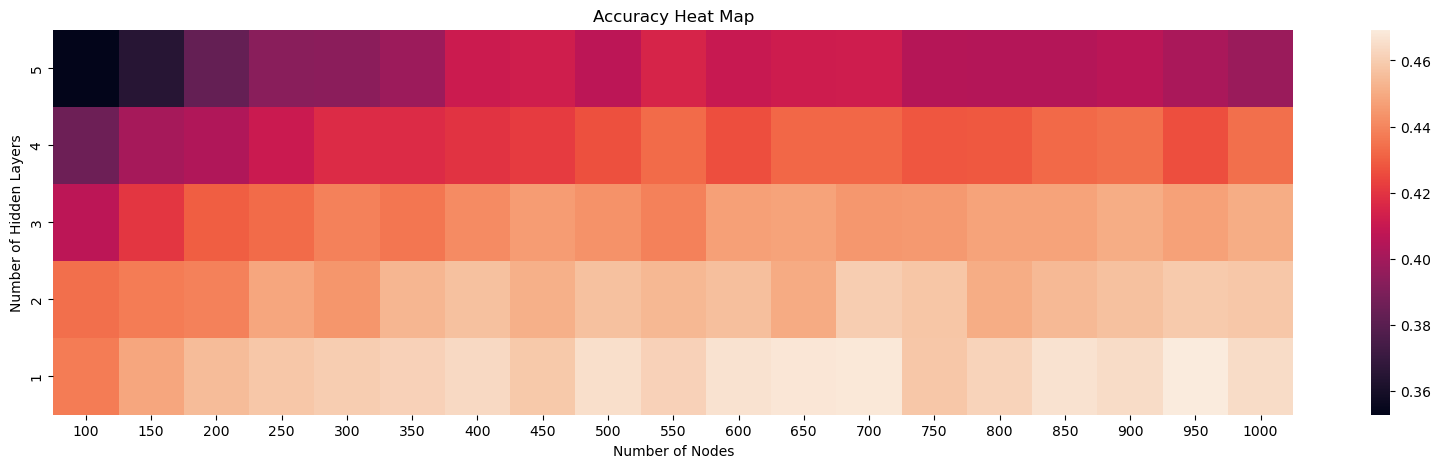

In [35]:
import seaborn as sns
# create the heatmap using seaborn
hmlist = acc_node_layer[::-1]
fig, ax = plt.subplots(figsize=(20,5))
heatmap = sns.heatmap(hmlist,ax=ax)
heatmap.set_xlabel('Number of Nodes')
heatmap.set_ylabel('Number of Hidden Layers')
heatmap.set_xticklabels(list(range(100,1050,50)))
heatmap.set_yticklabels([5,4,3,2,1])
plt.title('Accuracy Heat Map')
plt.show()

By inspection, small number of hidden layers with large nodes perform the best. We examine if increasing nodes further leads to a better performance. We focus on layer size = 1 and 2

By inspection, NN performs well for small size of layers and large number of nodes, we perform another study to examine this relationship in detail.

In [36]:
max_hidden_layer = 2
node_max_multiplier = 21
learning_rate,num_epochs,batch_size,drop = 0.002,550,250,0.2
acc_node_layer2 = [[0] * node_max_multiplier for _ in range(max_hidden_layer)]

for i in tqdm(range(max_hidden_layer),leave=False):
    for j in tqdm(range(node_max_multiplier),leave=False):
        node_list = [1000+50*j]*(i+1)
        accuracy = 0
        count = 100
        for k in tqdm(range(count),leave=False):
            X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X_train,y_train,
                                                                                    test_size=0.2,
                                                                                    random_state=random.seed(time.time()))
            _,_,_,_, acc_temp = model_examination(learning_rate, num_epochs, batch_size, node_list, drop,
                                                  X_train_temp, y_train_temp, X_test_temp, y_test_temp)
            accuracy += acc_temp
        acc_node_layer2[i][j] = accuracy/count

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

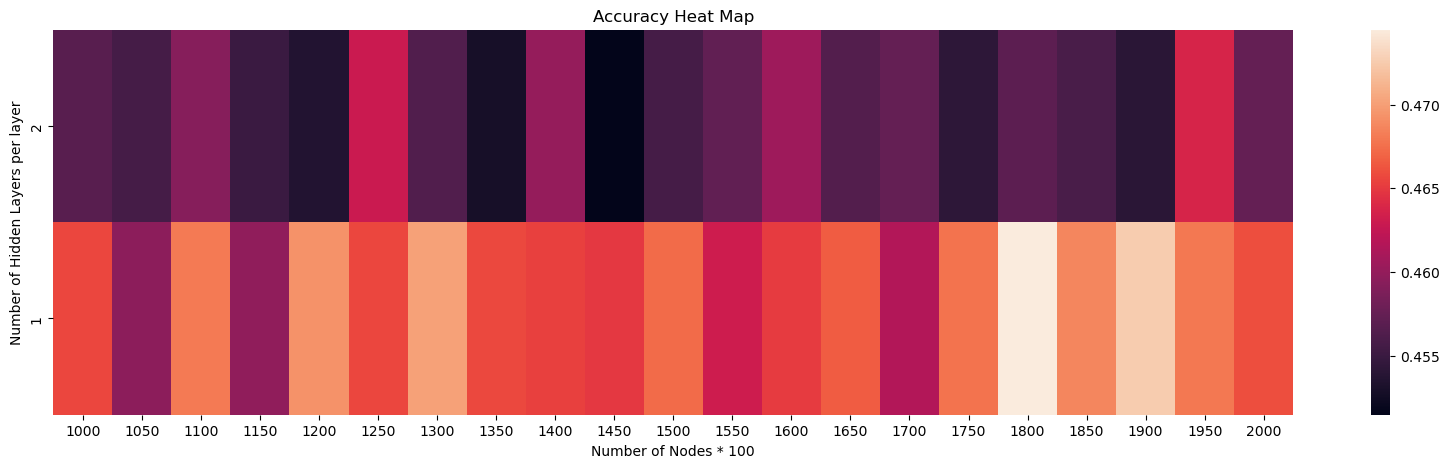

In [40]:
# create the heatmap using seaborn
hmlist3 = acc_node_layer2[::-1]
fig, ax = plt.subplots(figsize=(20,5))
heatmap3 = sns.heatmap(hmlist3,ax=ax)
heatmap3.set_xlabel('Number of Nodes * 100')
heatmap3.set_ylabel('Number of Hidden Layers per layer')
heatmap3.set_xticklabels(list(range(1000,2050,50)))
heatmap3.set_yticklabels([2,1])
plt.title('Accuracy Heat Map')
plt.show()


By observation, we believe 1 hidden layer yields better result in general, especially when the number of nodes increases. We now focus on having 1 hidden layers. In particular, we examine if number of nodes really affect the accuracy.

In [90]:
node_max_multiplier = 39
count = 500

learning_rate,num_epochs,batch_size,drop = 0.002,550,250,0.2
acc_validation = []
acc_test = []

for j in tqdm(range(node_max_multiplier)):
    node_list = [100+50*j]
    acc_validation_temp = []
    acc_test_temp = []
    for k in tqdm(range(count),leave=False):
        X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X_train,y_train,
                                                                                test_size=0.2,
                                                                                random_state=random.seed(time.time()))
        
        model_temp,_,_,_, acc_temp = model_examination(learning_rate, num_epochs, batch_size, node_list, drop,
                                              X_train_temp, y_train_temp, X_test_temp, y_test_temp)
        
        _,_,acc_actual_temp = predict(model_temp,X_test,y_test)
        
        acc_validation_temp.append(acc_temp)
        acc_test_temp.append(acc_actual_temp.cpu())
        
    acc_validation.append(acc_validation_temp)
    acc_test.append(acc_actual_temp)

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

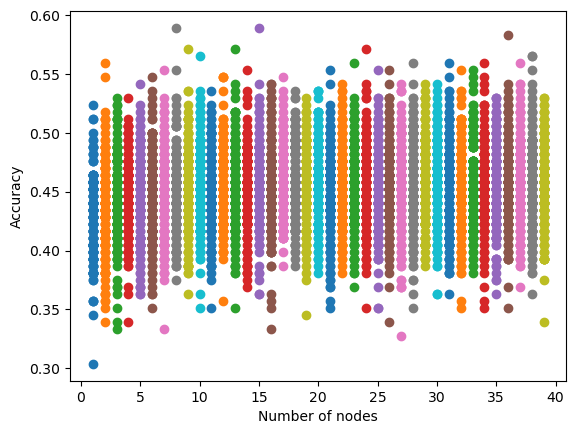

In [74]:
# Plot
fig, ax = plt.subplots()
for i, lst in enumerate(acc_node_hidden1):
    x = [i+1]*len(lst)
    ax.scatter(x,lst)
ax.set_xlabel('Number of nodes')
ax.set_ylabel('Accuracy')
plt.show()

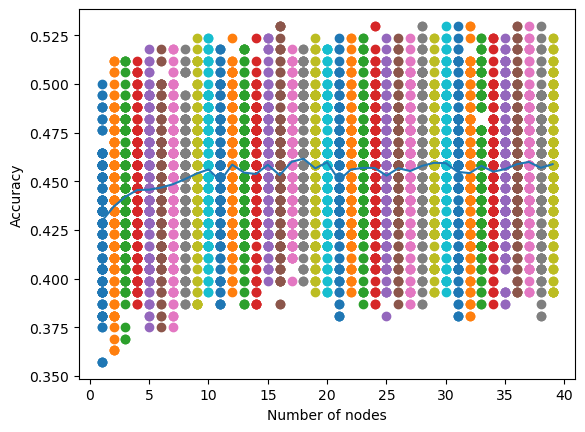

In [87]:
# Remove outliers
def remove_outliers(lst):
    threshold = 2
    mean = np.mean(lst)
    std = np.std(lst)
    z_scores = [(x-mean)/std for x in lst]
    return [x for x, z in zip(lst,z_scores) if abs(z) < threshold]
cleaned_list_of_lists = [remove_outliers(lst) for lst in acc_node_hidden1]

# Extract means
means = []
for lst in acc_node_hidden1:
    mean = sum(lst)/len(lst)
    means.append(mean)
    
fig, ax = plt.subplots()
for i, lst in enumerate(cleaned_list_of_lists):
    x = [i+1]*len(lst)
    ax.scatter(x,lst)
plt.plot(range(1,len(means)+1),means)
ax.set_xlabel('Number of nodes')
ax.set_ylabel('Accuracy')
plt.show()

In the beginning, the accuracy does seem to increase along with the number of noeds. This stops at around 10 and the rest turbulence seem to be random noises.

In [89]:
print(i)

38


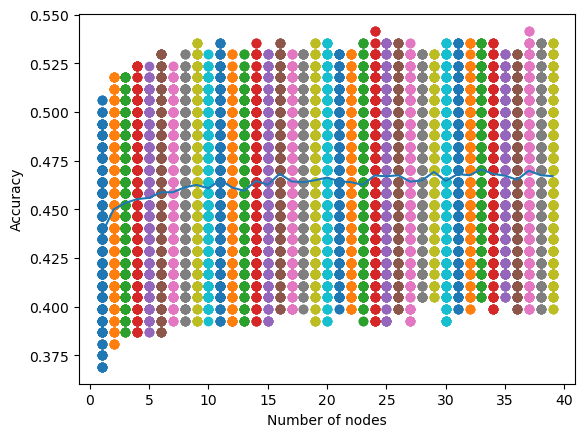

In [103]:
# Plot
cleaned_lst2 = [remove_outliers(lst) for lst in acc_validation]

means2 = []
for lst in cleaned_lst2:
    mean = sum(lst)/len(lst)
    means2.append(mean)

fig, ax = plt.subplots()
for i, lst in enumerate(cleaned_lst2):
    x = [i+1]*len(lst)
    ax.scatter(x,lst)
plt.plot(range(1,len(means2)+1),means2)
ax.set_xlabel('Number of nodes')
ax.set_ylabel('Accuracy')
plt.show()